In [1]:
"""
    This script creates a figuire containing 3 helicorder dayplots for CC.SEP and
    a location map of CC.SEP, CC.SUG, CC.HOA.

    To dos:
       Implement checks and try/except for error management.
       Consider where unit tests would be useful, and implement.
       Consider a class def for managing dayplot/subplot layouts.
"""


'\n    This script creates a figuire containing 3 helicorder dayplots for CC.SEP and \n    a location map of CC.SEP, CC.SUG, CC.HOA.\n\n    To dos:\n       Implement checks and try/except for error management.\n       Consider where unit tests would be useful, and implement.\n       Consider a class def for managing dayplot/subplot layouts.\n'

In [2]:
%pip install obspy==1.4.1
%pip install cartopy

  Using cached Cartopy-0.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
Using cached Cartopy-0.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)


In [3]:
import obspy
from obspy import read
from obspy.clients.fdsn import Client
import sqlite3
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.transforms import offset_copy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpr
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)


In [4]:
!wget https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP01.mseed https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP02.mseed https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP03.mseed

--2025-01-02 16:08:13--  https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP01.mseed
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CHIGHT-USGS/SeismicData/refs/heads/main/SEP/SEP01.mseed [following]
--2025-01-02 16:08:13--  https://raw.githubusercontent.com/CHIGHT-USGS/SeismicData/refs/heads/main/SEP/SEP01.mseed
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9957376 (9.5M) [application/octet-stream]
Saving to: ‘SEP01.mseed’

SEP01.mseed         100%[===================>]   9.50M  --.-KB/s    in 0.1s    

2025-01-02 16:08:14 (90.4 MB/s) - ‘SEP01.mseed’ saved [9957376/9957376

In [5]:
def readData(file):
    """Open and read a binary file.  Return contents.
       Consider updating to deal with large files via chunking or other method.

    Args:
        file: Reference to a file.

    Returns:
        File contents.
    """
    with open(file, 'rb') as fl:
        data = fl.read()
    return data


In [6]:
def db_init(conn, cur):
    """Create database for storing info about miniseed file and data.

    Args:
        conn: db connection

    Returns:
        Cursor for connecting with databaes.

    Three tables are created.
    sncl: "serial number" for uniquely identifying the channel at a location for
    a station on a network.
    timespans: maintain list of epoch-based start and end times for which data
    exists.  pkey is snclID.
    waveforms: store BLOB of waveform data.  pkeys are snclID and tsID.

    """

    cur.execute('''CREATE TABLE IF NOT EXISTS sncl(
     snclID INTEGER PRIMARY KEY AUTOINCREMENT,
     network TEXT NOT NULL,
     station TEXT NOT NULL,
     channel TEXT NOT NULL,
     location TEXT,
     CHECK (length(network) <= 2 and length(station) <= 5 and
     length(channel) == 3 and length(location) <= 2))''')

    # Needs a contraint to prevent overwriting timespans and data
    cur.execute('''CREATE TABLE IF NOT EXISTS timespans(
     tsID INTEGER PRIMARY KEY AUTOINCREMENT,
     snclID INTEGER,
     starttime TEXT NOT NULL,
     endtime TEXT NOT NULL,
     FOREIGN KEY(snclID) REFERENCES sncl(snclID))''')

    cur.execute('''CREATE TABLE IF NOT EXISTS waveforms(
     wfID INTEGER PRIMARY KEY AUTOINCREMENT,
     snclID INTEGER,
     tsID INTEGER,
     waveform BLOB,
     FOREIGN KEY(snclID) REFERENCES sncl(snclID),
     FOREIGN KEY(tsID) REFERENCES timespans(tsID))''')

    conn.commit()

In [7]:
def daysubplot(file, position):
    """Create a dayplot for specified miniseed file.

    Args:
        file: miniseed file
        gridspec x,y coords (future)

    Returns:
        axes subplot

    To do:
        Improve flexability by specifying both x,y coords as args

    """
    ax1 = fig.add_subplot(gs[0:2, position])
    file = files[0] + ".png"
    img = mpimg.imread(file)
    ax1.imshow(img)
    ax1.text(0.50,-0.30, texts[0], size=10, ha="center", transform=ax1.transAxes)
    ax1.set_xticks([])
    ax1.set_yticks([])


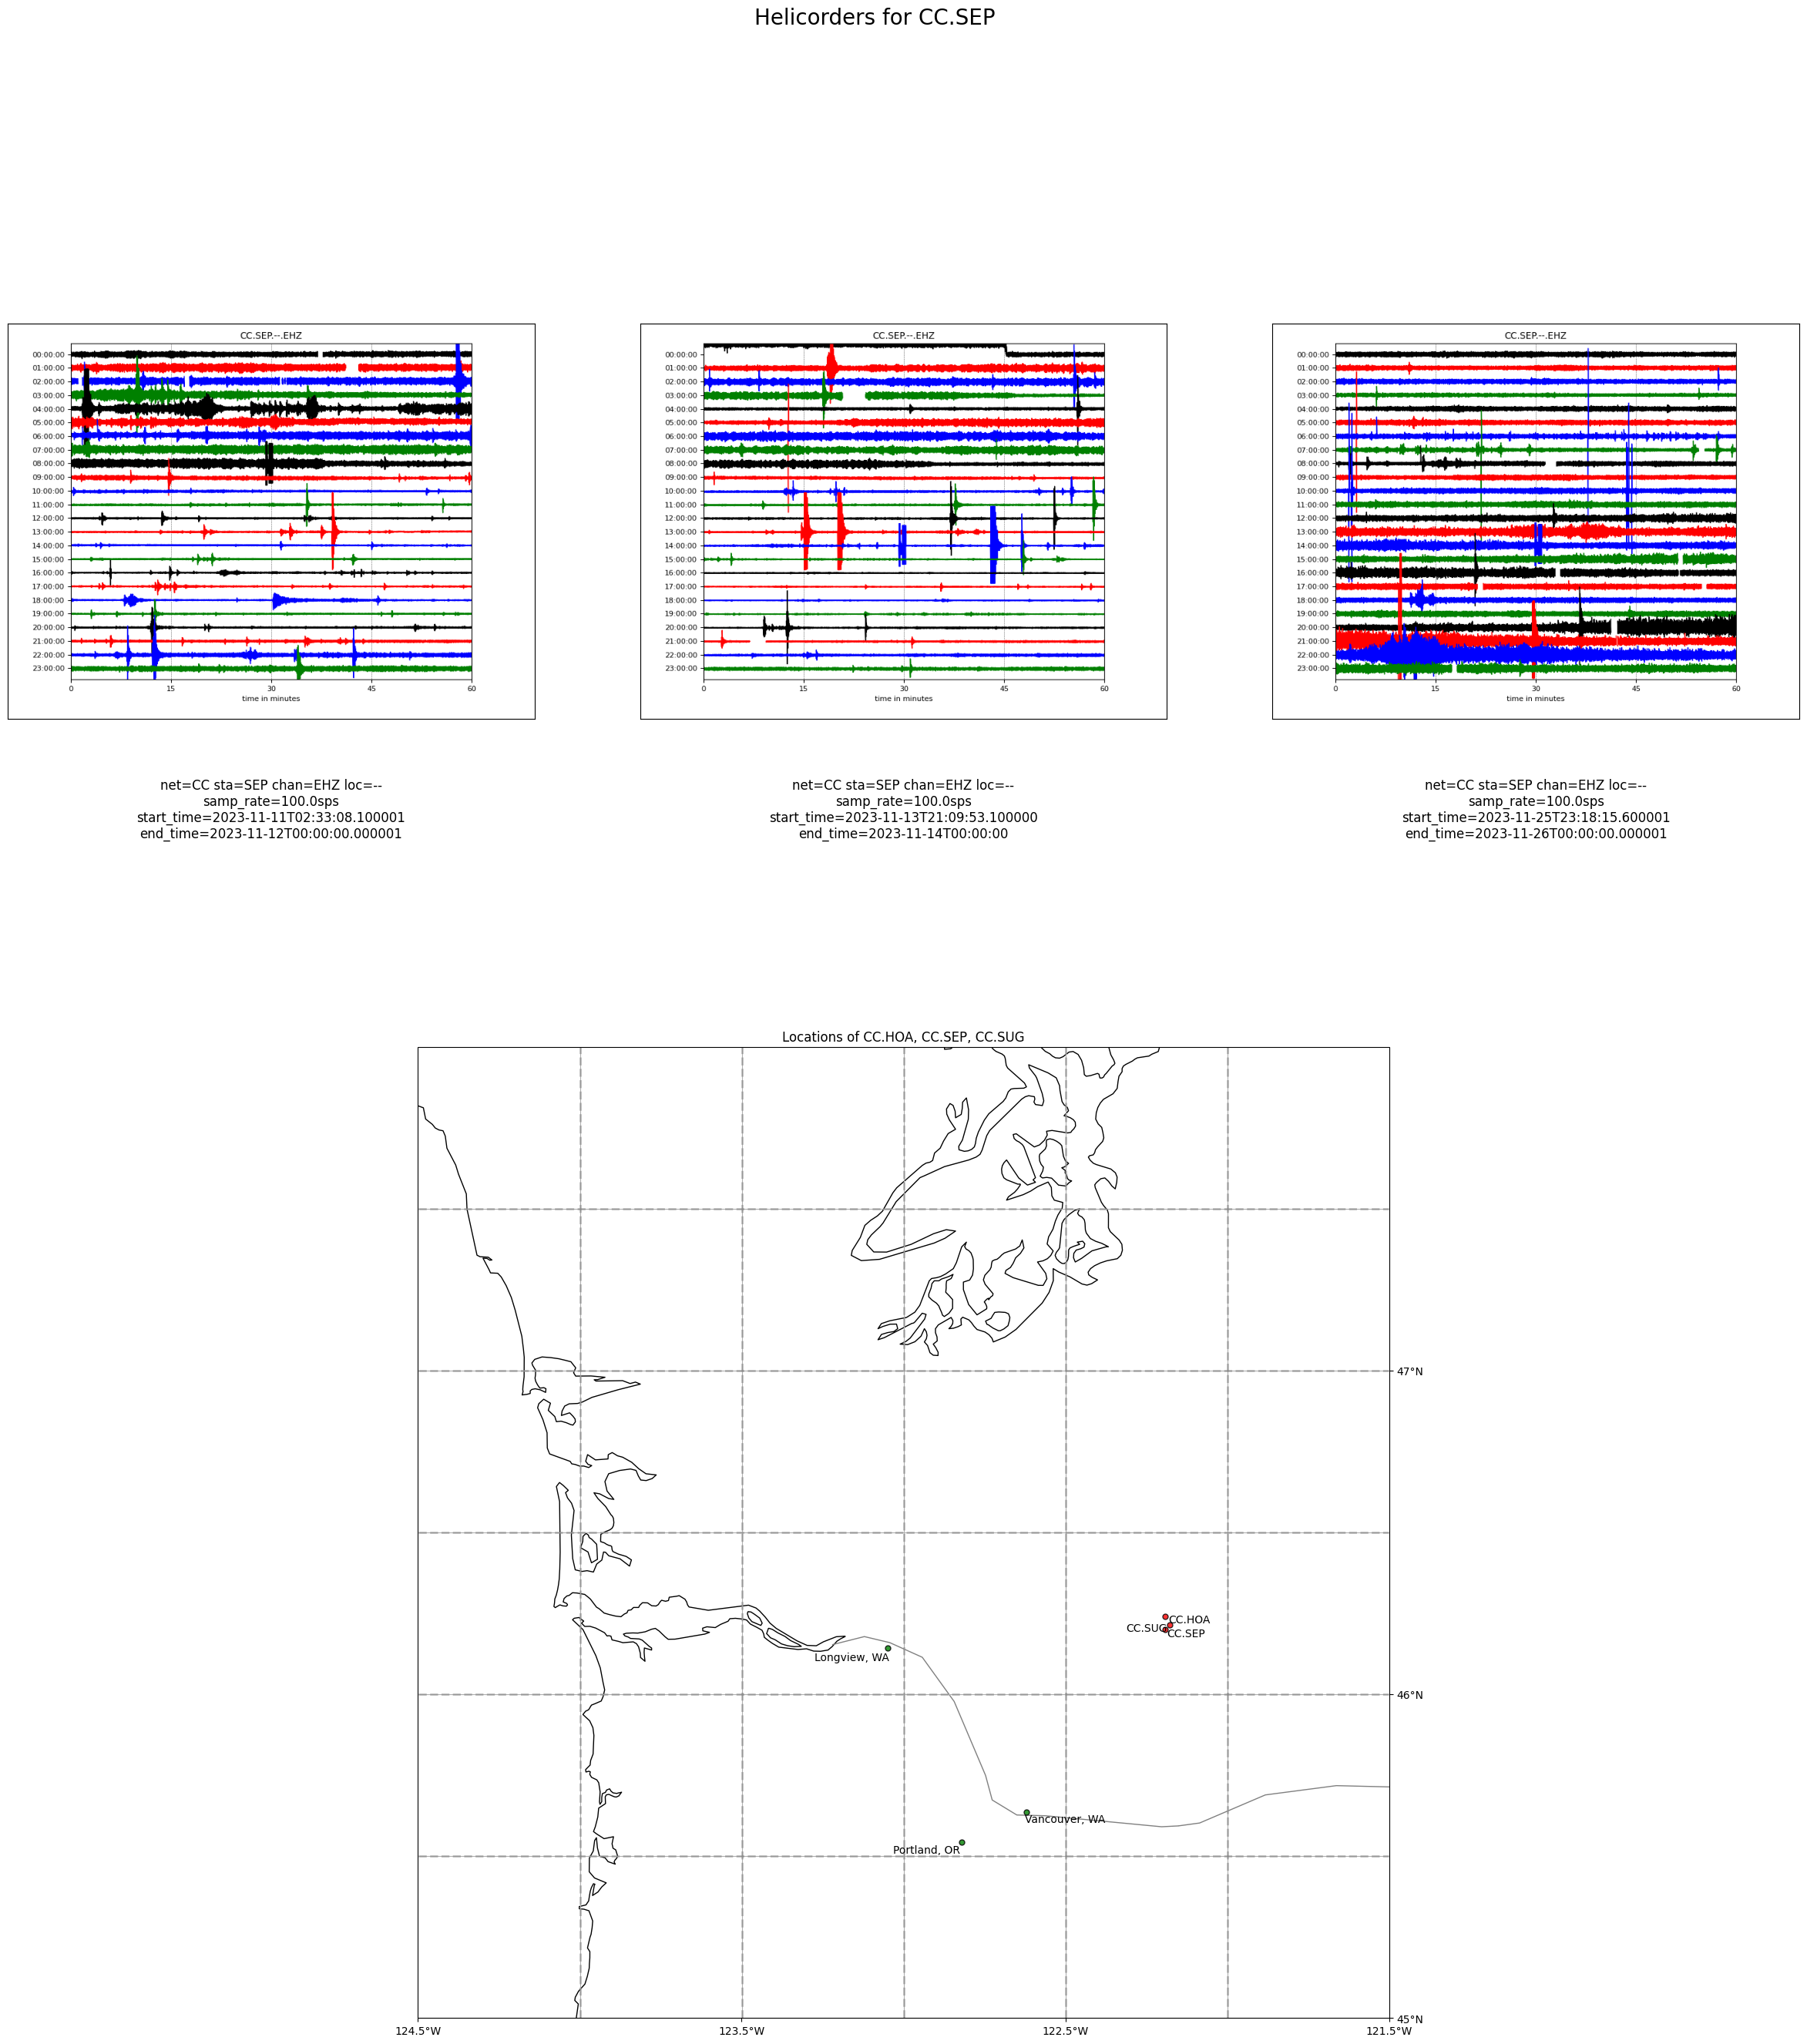

In [16]:
def main():
    %matplotlib inline

    # Variable defs
    files = ['SEP01.mseed', 'SEP02.mseed', 'SEP03.mseed']
    poi = {
    #'Mt St Helens, WA': {'lat': 46.1914279, 'lon': -122.2161505, 'x_off': -3, 'y_off': 4, 'v_al': 'bottom', 'h_al': 'right'},
    'Longview, WA': {'lat': 46.1423832, 'lon': -123.0479561,'x_off': 2, 'y_off': -5, 'v_al': 'top', 'h_al': 'right'},
    'Vancouver, WA': {'lat': 45.6374489, 'lon': -122.6195066, 'x_off': -2, 'y_off': -3, 'v_al': 'top', 'h_al': 'left'},
    'Portland, OR': {'lat': 45.5428359, 'lon': -122.819216411, 'x_off': -2, 'y_off': -3, 'v_al': 'top', 'h_al': 'right'}}

    # Instantiate an EarthScope FDSNWS client for obtaining station inventory
    client = Client("IRIS")

    # Establish a matplotlib figuire for subplots.
    # Use gridspec method for managing subplot layout.
    fig = plt.figure(figsize=(30,30))
    gs = fig.add_gridspec(5, 3)

    plusone = 0
    imgcount = 0
    # Maintain a list of texts containing miniseed file metadata
    texts = []
    # Maintain a dictionary of station info. ie. lat,lon,offsets for map.
    visualization = {}

    # Initialize database for storing miniseed file info, data.
    try:
        os.remove('waveforms.db')
    except OSError:
        pass

    conn = sqlite3.connect('waveforms.db')
    cur = conn.cursor()
    db_init(conn, cur)

    # Read miniseed stream and create blob for db storage.
    for file in files:
        st = obspy.read(file)
        blob = readData(file)

        # Get gap time ranges of data for database
        timespans = st.get_gaps()

        # Get metadata for each trance within data stream
        for trace in range(len(st)):
            network = st[trace].stats.network
            station = st[trace].stats.station
            channel = st[trace].stats.channel
            location = st[trace].stats.location
            srate = st[trace].stats.sampling_rate
            numpts = st[trace].stats.npts
            format = st[trace].stats._format
            delta = st[trace].stats.delta
            starttimeISO = st[trace].stats.starttime.isoformat()
            endtimeISO = st[trace].stats.endtime.isoformat()
            starttime = st[trace].stats.starttime._get_timestamp()
            endtime = st[trace].stats.endtime._get_timestamp()

            # Create db entries
            with conn:
                sqlqry = "SELECT * FROM sncl \
                WHERE network = ? and station = ? and channel = ? and location = ?"
                cur.execute(sqlqry, (network, station, channel, location))
                rows = cur.fetchall()

                if len(rows) == 0:
                    sqlins = "INSERT INTO sncl (network, station, channel, location) \
                    VALUES (?,?,?,?) RETURNING snclID"
                    cur.execute(sqlins, (network, station, channel, location))
                    row = cur.fetchone()
                    (snclPKEY, ) = row if row else None

                cur.execute(sqlqry, (network, station, channel, location))
                rows = cur.fetchall()

                sqlins = "INSERT INTO timespans (snclID, starttime, endtime) \
                VALUES (?,?,?) RETURNING tsID"
                cur.execute(sqlins, (snclPKEY, starttime, endtime))
                row = cur.fetchone()
                (tsPKEY, ) = row if row else None

                sqlins = "INSERT INTO waveforms (snclID, tsID, waveform) VALUES (?,?,?)"
                cur.execute(sqlins, (snclPKEY, tsPKEY, blob))

        # Create list of texts containing miniseed file metadata for helicorders
        text = (f'net={network} sta={station} chan={channel} loc={location}\nsamp_rate={srate}sps\nstart_time={starttimeISO}\nend_time={endtimeISO}')
        texts.append(text)

        # Commit dayplot to file
        st.plot(show=False, type="dayplot", interval=60, right_vertical_labels=False,
        vertical_scaling_range=5e3, one_tick_per_line=True,
        color=['k', 'r', 'b', 'g'], show_y_UTC_label=False,outfile=str(file)+".png")
        plusone = plusone + 1

        # Collect station info for CC.SEP.  ie. location
        inventory = client.get_stations(network="CC", station="SEP", level="station")
        for network in inventory:
            for station in network:
                NS = str(network.code) + "." + str(station.code)
                if ((NS) not in visualization):
                    visualization[NS] = {'ns': NS, 'dayplot': str(file)+".png",
                                       'lat': station.latitude,
                                       'lon': station.longitude,
                                       'elev': station.elevation,
                                       'x_off': 2, 'y_off': 2,
                                       'v_al': 'top', 'h_al': 'left'}

    # Create helicorder displays
    ax1 = fig.add_subplot(gs[0:2,0])
    file = files[0] + ".png"
    img = mpimg.imread(file)
    ax1.imshow(img)
    ax1.text(0.50,-0.30, texts[0], size=12, ha="center", transform=ax1.transAxes)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = fig.add_subplot(gs[0:2,1])
    file = files[1] + ".png"
    img = mpimg.imread(file)
    ax2.imshow(img)
    ax2.text(0.50,-0.30, texts[1], size=12, ha="center", transform=ax2.transAxes)
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3 = fig.add_subplot(gs[0:2,2])
    file = files[2] + ".png"
    img = mpimg.imread(file)
    ax3.imshow(img)
    ax3.text(0.50,-0.30, texts[2], size=12, ha="center", transform=ax3.transAxes)
    ax3.set_xticks([])
    ax3.set_yticks([])

    fig.suptitle('Helicorders for CC.SEP', fontsize=20)
    plt.subplots_adjust(hspace=1.5)

    # Collect station info for CC.SUG and CC.HUA.  ie. location
    idx = 0
    inventory = client.get_stations(network="CC", station="HOA,SUG", level="station")
    for network in inventory:
        for station in network:
            NS = str(network.code) + "." + str(station.code)
            h_al = ("right", "left")[idx % 2 == 0]
            x_off = (-4, 4)[idx % 2 == 0]
            idx+=1
            if ((NS) not in visualization):
                visualization[NS] = {'ns': NS, 'dayplot': '',
                                     'lat': station.latitude,
                                     'lon': station.longitude,
                                     'elev': station.elevation,
                                     'x_off': x_off, 'y_off': 2,
                                     'v_al': 'top', 'h_al': h_al}

    # Create map of stations
    #  To do: If continue using Cartopy, preload/save features.
    map_proj = ccrs.PlateCarree(central_longitude=-122)
    ax4 = fig.add_subplot(gs[2:, :], projection=map_proj,)
    ax4.set_global()
    ax4.gridlines()
    #ax4.add_feature(cfeature.LAND)
    #ax4.add_feature(cfeature.OCEAN)
    ax4.add_feature(cfeature.COASTLINE)
    ax4.set_extent([-122.00, -123.50, 45.5, 48.0])

    # Add state boundary lines to map
    states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
    ax4.add_feature(states_provinces, edgecolor='gray')

    transform = ccrs.PlateCarree()._as_mpl_transform(ax4)
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax4)

    # Add stations to map
    # Better logic/an algortihm likely needed to ensure dots and text
    #  do not overlap.
    for name, data in visualization.items():
        text_transform = offset_copy(geodetic_transform, units='dots',
                                     x=data['x_off'], y=data['y_off'])
        ax4.plot(data['lon'], data['lat'], marker='o', markersize=5, color='red',
                 markeredgecolor='black', alpha=0.8, transform=geodetic_transform)
        ax4.text(data['lon'], data['lat'], name, fontsize=10,
                verticalalignment=data['v_al'],
                horizontalalignment=data['h_al'],
                transform=text_transform)
        #ax4.annotate('', xy=(data['lon'], data['lat']),
        #             xytext=(data['lon']+data['x_off'], data['lat']+data['y_off']),
        #            arrowprops=dict(arrowstyle='->', color='black'))

    # Add points of interest to map
    for name, data in poi.items():
        text_transform = offset_copy(geodetic_transform, units='dots',
                                 x=data['x_off'], y=data['y_off'])
        ax4.plot(data['lon'], data['lat'], marker='o', markersize=5, color='green',
             markeredgecolor='black', alpha=0.8, transform=geodetic_transform)
        ax4.text(data['lon'], data['lat'], name,
            verticalalignment=data['v_al'],
            horizontalalignment=data['h_al'],
            transform=text_transform)

    ax4.set_title('Locations of CC.HOA, CC.SEP, CC.SUG')

    # Add tick marks and lat/long grid lines to map
    ax4.yaxis.tick_right()
    ax4.set_xticks([-121.50,-122.50,-123.50,-124.50], crs=ccrs.PlateCarree())
    ax4.set_yticks([45,46,47], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax4.xaxis.set_major_formatter(lon_formatter)
    ax4.yaxis.set_major_formatter(lat_formatter)
    gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   linewidth=2, color='gray', alpha=0.5, linestyle='--')

    plt.show()


if __name__=="__main__":
    main()